In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c state-farm-distracted-driver-detection

100% 4.00G/4.00G [00:28<00:00, 159MB/s]
100% 4.00G/4.00G [00:28<00:00, 151MB/s]


In [ ]:
! unzip /content/state-farm-distracted-driver-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: imgs/train/c7/img_56636.jpg  
  inflating: imgs/train/c7/img_56661.jpg  
  inflating: imgs/train/c7/img_56699.jpg  
  inflating: imgs/train/c7/img_56717.jpg  
  inflating: imgs/train/c7/img_56724.jpg  
  inflating: imgs/train/c7/img_56768.jpg  
  inflating: imgs/train/c7/img_56779.jpg  
  inflating: imgs/train/c7/img_56849.jpg  
  inflating: imgs/train/c7/img_56899.jpg  
  inflating: imgs/train/c7/img_56938.jpg  
  inflating: imgs/train/c7/img_5706.jpg  
  inflating: imgs/train/c7/img_57076.jpg  
  inflating: imgs/train/c7/img_57122.jpg  
  inflating: imgs/train/c7/img_57137.jpg  
  inflating: imgs/train/c7/img_5715.jpg  
  inflating: imgs/train/c7/img_57278.jpg  
  inflating: imgs/train/c7/img_57321.jpg  
  inflating: imgs/train/c7/img_57345.jpg  
  inflating: imgs/train/c7/img_57355.jpg  
  inflating: imgs/train/c7/img_5741.jpg  
  inflating: imgs/train/c7/img_57433.jpg  
  inflating: imgs/train/c7/img_5753.jpg  
  infla

# Import Libraries

In [ ]:
#Files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob

#DATA
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

#CNN
from tensorflow.keras import layers
from keras import models 
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint

#VIS
from keras.utils.vis_utils import plot_model

# Preprocessing Data

In [ ]:
def preparData(path):
  imagsList = []
  labels = []
  for dic in sorted(glob.glob(os.path.join(path,'*')), key = lambda k: k.split('/')[-1]):
    for imgs in glob.glob(os.path.join(dic, '*.jpg')):
      img = cv2.imread(imgs)
      img_r = cv2.resize(img,(128,128))
      imagsList.append(img_r)
      labels.append(int(dic.split("/")[-1].replace('c','')))
  
  X_train, X_test, y_train, y_test = train_test_split(imagsList, labels, test_size=0.2,shuffle= True, random_state = 0)
  y_train = to_categorical(y_train)
  y_test  = to_categorical(y_test)

  return np.array(X_train), np.array(X_test), y_train, y_test


# Get Data

In [ ]:
path_train = "/content/imgs/train/"
path_test  = "/content/imgs/test/"

X_train, X_test, y_train, y_test = preparData(path_train)

print(f"Size X_train: {len(X_train)}, Size y_train: {len(y_train)}")
print(f"Size X_test: {len(X_test)}, Size y_test {len(y_test)}")

Size X_train: 17939, Size y_train: 17939
Size X_test: 4485, Size y_test 4485


# VGG16 Model

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (128, 128, 3))

conv_base.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
conv_base.trainable = False
vgg_model_1 = models.Sequential()
vgg_model_1.add(conv_base)
vgg_model_1.add(layers.Flatten())
vgg_model_1.add(layers.Dense(units=512, activation='relu'))
vgg_model_1.add(layers.Dense(units=256, activation='relu'))
vgg_model_1.add(layers.Dense(units=128, activation='relu'))
vgg_model_1.add(layers.Dense(units=64, activation='relu'))
vgg_model_1.add(layers.Dense(units=10,activation='softmax'))
vgg_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               4194816   
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 10)               

**Plot Model**

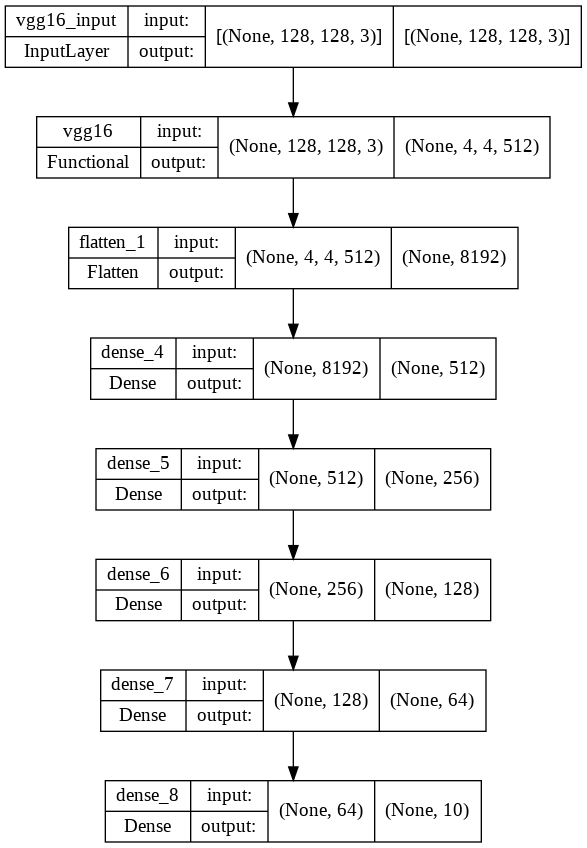

In [ ]:
plot_model(vgg_model_1,show_shapes=True)

**Model Compile**

In [ ]:
vgg_model_1.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
vgg_history = vgg_model_1.fit(X_train, y_train, epochs = 10, batch_size = 512, validation_split = 0.2)

Epoch 1/10
29/29 [==============================] - 52s 1s/step - loss: 9.2594 - accuracy: 0.3175 - val_loss: 1.0436 - val_accuracy: 0.6957
Epoch 2/10
29/29 [==============================] - 28s 987ms/step - loss: 0.3793 - accuracy: 0.8857 - val_loss: 0.1583 - val_accuracy: 0.9548
Epoch 3/10
29/29 [==============================] - 28s 975ms/step - loss: 0.0972 - accuracy: 0.9744 - val_loss: 0.0843 - val_accuracy: 0.9788
Epoch 4/10
29/29 [==============================] - 28s 968ms/step - loss: 0.0512 - accuracy: 0.9889 - val_loss: 0.0641 - val_accuracy: 0.9841
Epoch 5/10
29/29 [==============================] - 28s 979ms/step - loss: 0.0271 - accuracy: 0.9960 - val_loss: 0.0562 - val_accuracy: 0.9872
Epoch 6/10
29/29 [==============================] - 28s 974ms/step - loss: 0.0176 - accuracy: 0.9985 - val_loss: 0.0534 - val_accuracy: 0.9866
Epoch 7/10
29/29 [==============================] - 28s 974ms/step - loss: 0.0132 - accuracy: 0.9992 - val_loss: 0.0471 - val_accuracy: 0.9891
Ep

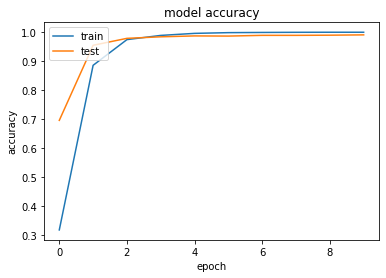

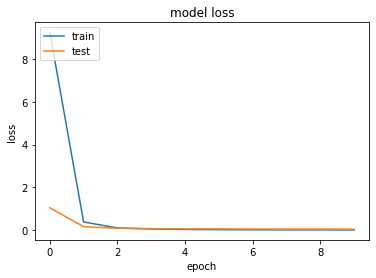

In [ ]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#Save Model

In [ ]:
vgg_model_1.save('model_online_feature.h5')